## Cài đặt thư viện

In [1]:
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dự đoán nhãn

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# --- Load model và tokenizer ---
model_path = "/content/drive/MyDrive/fine_tuned_mdeberta_factcheck"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# --- Đọc file JSON test ---
with open("test.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

# --- Map nhãn text sang số ---
label2id = {"SUPPORTS": 0, "REFUTES": 1}
id2label = {v: k for k, v in label2id.items()}

# Lấy nhãn thật dạng số
true_labels = [label2id.get(item['label'], -1) for item in test_data]

# --- Dự đoán ---
predicted_labels = []

for item in test_data:
    claim = item['claim']
    evidence = item['evidence']

    inputs = tokenizer(claim, evidence, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    pred_id = torch.argmax(logits, dim=1).item()
    predicted_labels.append(pred_id)

# --- Tính accuracy và classification report ---
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy trên tập test: {accuracy:.4f}")

print("Classification report:")
print(classification_report(true_labels, predicted_labels, target_names=list(label2id.keys())))

# --- Lưu kết quả dự đoán ra DataFrame rồi CSV ---
results = []
for i, item in enumerate(test_data):
    results.append({
        "claim": item["claim"],
        "evidence": item["evidence"],
        "true_label": item["label"],
        "true_label_id": true_labels[i],
        "predicted_label": id2label[predicted_labels[i]],
        "predicted_label_id": predicted_labels[i]
    })

df_results = pd.DataFrame(results)
df_results.to_csv("test_predicted_with_metrics.csv", index=False)

print("Đã lưu kết quả dự đoán và đánh giá vào test_predicted_with_metrics.csv")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Accuracy trên tập test: 0.9462
Classification report:
              precision    recall  f1-score   support

    SUPPORTS       0.97      0.94      0.95       670
     REFUTES       0.92      0.96      0.94       539

    accuracy                           0.95      1209
   macro avg       0.94      0.95      0.95      1209
weighted avg       0.95      0.95      0.95      1209

Đã lưu kết quả dự đoán và đánh giá vào test_predicted_with_metrics.csv


#  Báo cáo kết quả mô hình

## Confusion Matrix

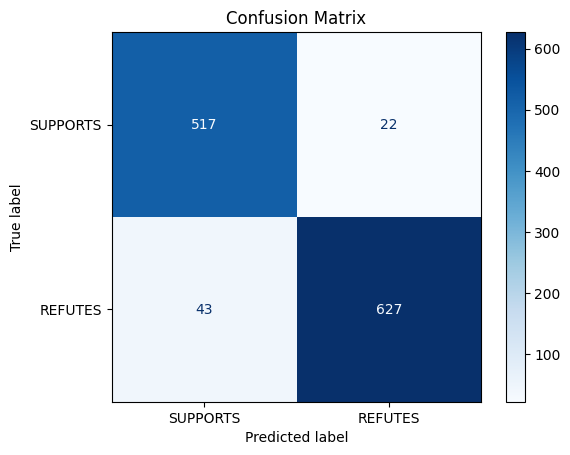

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("test_predicted_with_metrics.csv")
y_true = df["true_label"]
y_pred = df["predicted_label"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["SUPPORTS", "REFUTES"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


## Classification Report

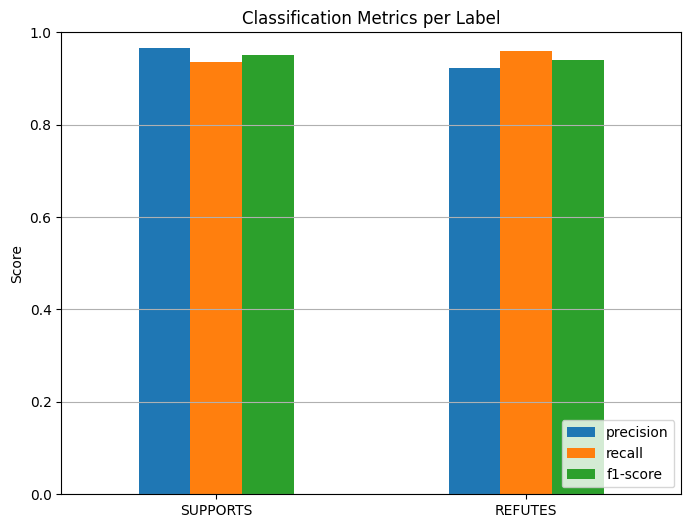

In [6]:
from sklearn.metrics import classification_report
import numpy as np

report = classification_report(df["true_label"], df["predicted_label"], output_dict=True)
classes = ["SUPPORTS", "REFUTES"]
metrics = ["precision", "recall", "f1-score"]

data = [[report[c][m] for m in metrics] for c in classes]
df_plot = pd.DataFrame(data, columns=metrics, index=classes)

df_plot.plot(kind="bar", figsize=(8,6))
plt.title("Classification Metrics per Label")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc="lower right")
plt.show()

## Biểu đồ Pie về phân phối nhãn dự đoán

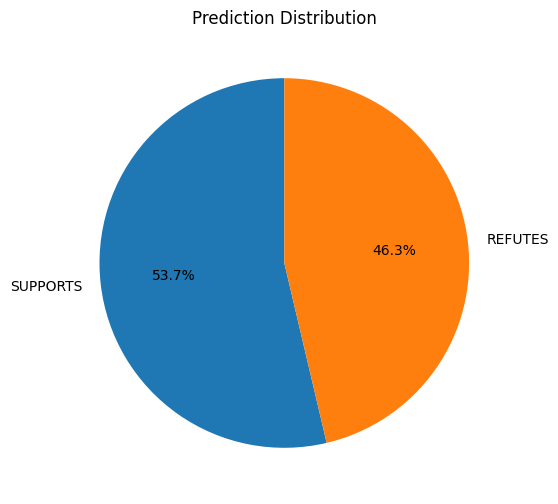

In [7]:
df["predicted_label"].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6,6), title="Prediction Distribution")
plt.ylabel("")
plt.show()